In [1]:
"""demo: test dndlstm on contextual evidence integration
- Use K as cues
"""

import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns
import time

from NN.MyDNDLSTM import MyDNDLSTM

%matplotlib inline 
%autosave 5

# 
sns.set(style='white', context='talk', font_scale=.9, rc={"lines.linewidth": 2.5})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device = {device}')
# 
seed_val = 0
torch.manual_seed(seed_val)
np.random.seed(seed_val)

Autosaving every 5 seconds
device = cpu


In [2]:
def get_an_training_example(vec_dim, T): 
    """
    evidence: 
        initially ambiguous, 
        after `tp_corrupt`, become predictive about the target
    """
    signal = 3
    evidence = np.random.normal(loc=signal*np.sign(np.random.normal()), size=(T, vec_dim))
    # integration results
    target_value = 1 if np.sum(evidence) > 0 else 0
    target = np.tile(target_value, (T,))
    # corrupt the evidence input 
    evidence[:tp_corrupt] = np.random.normal(loc=0, size=(tp_corrupt, vec_dim))
    # genreate a cue 
    cue = np.random.normal(size=(vec_dim, ))
    return evidence, cue, target

def get_training_examples(vec_dim, T, m): 
    evidences = [None] * m
    cues = [None] * m 
    targets = [None] * m 
    for i in range(m): 
        evidences[i], cues[i], targets[i] = get_an_training_example(vec_dim, T)
    return evidences, cues, targets

def gen_data_wrapper(vec_dim, T, M):
    # gen data
    evidences, cues, targets = get_training_examples(vec_dim, T, M)
    # build in reoccurence structure
    perm = np.random.permutation(len(evidences))
    evidences += [evidences[i] for i in perm]
    cues += [cues[i] for i in perm]
    targets += [targets[i] for i in perm]

    # reshape data
    X = np.array([np.expand_dims(evidences[i], axis=-1) for i in range(len(evidences))])
    K = np.array([cues[i] for i in range(len(evidences))])
    Y = np.array([targets[i] for i in range(len(evidences))])

    # to pytorch form 
    X = torch.from_numpy(X).type(torch.FloatTensor).to(device)
    K = torch.from_numpy(K).type(torch.FloatTensor).to(device)
    Y = torch.from_numpy(Y).type(torch.FloatTensor).to(device)
    return X, K, Y

In [3]:
# gen training set 
# n time steps of a trial
T = 10
# after `tp_corrupt`, turn off the noise
tp_corrupt = 5
# input/output/hidden/memory dim 
vec_dim = 23
# n training examples in one epoch 
M = 53

# X, K, Y = gen_data_wrapper(vec_dim, T, M)

# print(f'X.size: {X.size()}, M x T X V x dummy_dim')
# print(f'K.size: {K.size()}, M x T X V x dummy_dim')
# print(f'Y.size: {Y.size()}, M x T X V x dummy_dim')

In [4]:
# set params
dim_input = vec_dim
dim_hidden = vec_dim
dim_output = 1
dim_memory = vec_dim
dict_len = 100
kernel = 'l2'
learning_rate = 3e-5

# init model and hidden state.
lstm = MyDNDLSTM(dim_input, dim_hidden, dict_len, dim_memory, kernel).to(device)
readout = nn.Linear(dim_hidden, dim_output).to(device)

# initial condition 
h_0 = torch.zeros(1, 1, dim_hidden).to(device)
c_0 = torch.zeros(1, 1, dim_hidden).to(device)
# init optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(
    list(lstm.parameters())+list(readout.parameters()), 
    lr=learning_rate
)

In [5]:
# train params
n_epochs = 50
clip_grad_norm_val = 1

# loop over epoch
losses = np.zeros(n_epochs,)
for i in range(n_epochs):
    time_start = time.time()

    # get data for this epoch 
    X, K, Y = gen_data_wrapper(vec_dim, T, M)
    
    # flush hippocampus 
    lstm.dnd.reset_memory()
    
    # loop over the training set 
    for m in range(len(Y)): 
        x_m = X[m]
        k_m = K[m]
        y_m = Y[m]

        # loop over time, for one training example
        for t in range(T):
            # flush cortex
            if t == 0:
                h_t = h_0
                c_t = c_0 
            
            # only save memory at the last time point 
            lstm.dnd.encoding_off = True
            if t == T-1 and m < M: 
                lstm.dnd.encoding_off = False
            
            # recurrent computation at time t
            out, h_t, c_t, _ = lstm(x_m[t].view(1, 1, -1), h_t, c_t, k_m)
            out_val = readout(out)
            y_hat = out_val
            y_hat = torch.squeeze(y_hat)
            
            # compute loss
            loss = criterion(y_hat, y_m[t])
            losses[i] += loss.item()

            # update weights
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            nn.utils.clip_grad_norm_(lstm.parameters(), clip_grad_norm_val)
            optimizer.step()

    # print out some stuff
    time_end = time.time()
    print(f'Epoch {i} | \t loss = {losses[i]}, \t time = {time_end - time_start}')

Epoch 0 | 	 loss = 495.3559259994422, 	 time = 1.8493340015411377
Epoch 1 | 	 loss = 167.08612454507823, 	 time = 1.8121609687805176
Epoch 2 | 	 loss = 164.43433762923112, 	 time = 1.8123908042907715
Epoch 3 | 	 loss = 151.1860651507107, 	 time = 1.9497122764587402
Epoch 4 | 	 loss = 126.70577514092591, 	 time = 1.9603111743927002
Epoch 5 | 	 loss = 125.97855092354084, 	 time = 2.3770806789398193
Epoch 6 | 	 loss = 134.6211500375892, 	 time = 1.9418020248413086
Epoch 7 | 	 loss = 118.6057040843036, 	 time = 1.8231029510498047
Epoch 8 | 	 loss = 146.9591108139682, 	 time = 1.8110809326171875
Epoch 9 | 	 loss = 114.80255381884977, 	 time = 1.8130888938903809
Epoch 10 | 	 loss = 123.98784398321733, 	 time = 1.8441431522369385
Epoch 11 | 	 loss = 115.93753917380073, 	 time = 1.885565996170044
Epoch 12 | 	 loss = 125.12642333084246, 	 time = 1.8598108291625977
Epoch 13 | 	 loss = 115.90609902784844, 	 time = 1.8320231437683105
Epoch 14 | 	 loss = 118.08471147044263, 	 time = 1.8439490795135

In [6]:
"""evaluate on test set"""

lstm.retrieval_off=False
lstm.encoding_off=False

Y_hat = np.zeros((len(Y), T))
Y_mt = np.zeros((len(Y), T))
f_t = [[None] * T for _ in range(len(Y))]
i_t = [[None] * T for _ in range(len(Y))]
o_t = [[None] * T for _ in range(len(Y))]
r_t = [[None] * T for _ in range(len(Y))]

with torch.no_grad():
    
    # get data for this epoch 
    X, K, Y = gen_data_wrapper(vec_dim, T, M)
    
    # flush hippocampus
    lstm.dnd.reset_memory()
    
    # loop over the training set 
    for m in range(len(Y)): 
        x_m = X[m]
        k_m = K[m]
        y_m = Y[m]

        # loop over time, for one training example
        for t in range(T):
            # flush cortex
            if t == 0:
                h_t = h_0
                c_t = c_0 
            
            # only save memory at the last time point 
            lstm.dnd.encoding_off = True
            if t == T-2 and m < M: 
                lstm.dnd.encoding_off = False
            
            # recurrent computation at time t
            out, h_t, c_t, cache = lstm(x_m[t].view(1, 1, -1), h_t, c_t, k_m)
            out_val = readout(out)
            y_hat = out_val
            y_hat = torch.squeeze(y_hat)
            
            # get info 
            Y_mt[m, t] = np.squeeze(y_m[t].numpy()) 
            Y_hat[m, t] = np.squeeze(y_hat.numpy())
            f_t[m][t], i_t[m][t], o_t[m][t], r_t[m][t] = cache
            
            
for m in range(len(Y)):
    for t in range(T):
        f_t[m][t] = np.squeeze(f_t[m][t].numpy())
        i_t[m][t] = np.squeeze(i_t[m][t].numpy())
        o_t[m][t] = np.squeeze(o_t[m][t].numpy())
        r_t[m][t] = np.squeeze(r_t[m][t].numpy())            

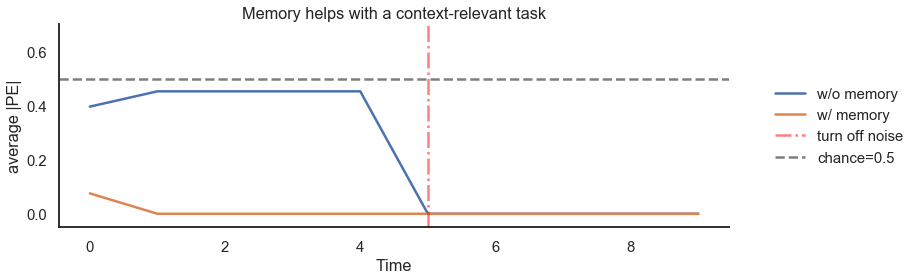

In [7]:
f, ax = plt.subplots(1,1, figsize=(11,4))

Y_hat = np.round(Y_hat)

pe1 = Y_hat[:M,:] - Y_mt[:M,:]
pe2 = Y_hat[M:,:] - Y_mt[M:,:]

abs_pe1 = np.mean(np.abs(pe1), axis=0)
abs_pe2 = np.mean(np.abs(pe2), axis=0)

ax.plot(abs_pe1, label='w/o memory')
ax.plot(abs_pe2, label='w/ memory')
ax.set_ylim([-.05,.7])

chance_val = .5
ax.axvline(tp_corrupt, color='red', linestyle='-.', alpha=.5, label='turn off noise')
ax.axhline(chance_val, color='black', linestyle='--', alpha=.5, label=f'chance={chance_val}')

ax.set_ylabel('average |PE|')
ax.set_xlabel('Time')
ax.set_title('Memory helps with a context-relevant task')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)

sns.despine()
f.tight_layout()

In [8]:
# plt.imshow(np.squeeze(np.array([lstm.vals[i].numpy() for i in range(len(lstm.keys))])))
# plt.imshow(np.squeeze(np.array([lstm.keys[i].numpy() for i in range(len(lstm.keys))])))
# plt.colorbar()

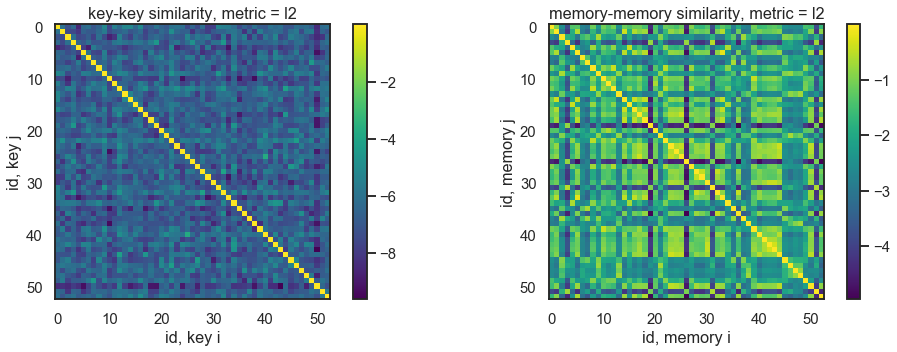

In [9]:
from NN.DND import compute_similarities

dmat_mm = np.zeros((len(lstm.dnd.keys),len(lstm.dnd.keys)))
dmat_kk = np.zeros((len(lstm.dnd.keys),len(lstm.dnd.keys)))

for i in range(len(lstm.dnd.keys)): 
    for j in range(len(lstm.dnd.keys)): 
        dmat_mm[i,j] = compute_similarities(
            lstm.dnd.vals[i], [lstm.dnd.vals[j]], lstm.dnd.kernel
        ).item()
        dmat_kk[i,j] = compute_similarities(
            lstm.dnd.keys[i], [lstm.dnd.keys[j]], lstm.dnd.kernel
        ).item()

# plot 
dmats = [dmat_kk, dmat_mm]        
labels = ['key', 'memory']

f, axes = plt.subplots(1, 2, figsize = (14,5))
for i, ax in enumerate(axes): 

    im = ax.imshow(dmats[i], cmap='viridis')
    f.colorbar(im, ax=ax)
    
    ax.set_xlabel(f'id, {labels[i]} i')
    ax.set_ylabel(f'id, {labels[i]} j')
    ax.set_title(f'{labels[i]}-{labels[i]} similarity, metric = {lstm.dnd.kernel}')

f.tight_layout()

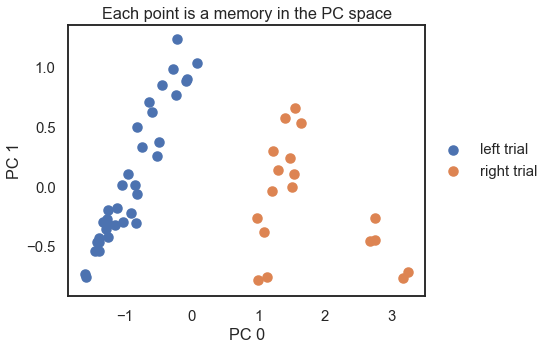

In [10]:
from sklearn.decomposition import PCA

# organize the values to a numpy array, #memories x mem_dim
all_keys = np.vstack([lstm.dnd.keys[i].numpy() for i in range(len(lstm.dnd.keys))])
all_vals = np.vstack([lstm.dnd.vals[i].numpy() for i in range(len(lstm.dnd.vals))])
all_ys = Y[:M, 0].numpy()

# embed the memory to PC space 
pca = PCA(n_components=10)
all_vals_pca = pca.fit_transform(all_vals)

# plot 
f, ax = plt.subplots(1,1, figsize = (8,5))

# pick pcs 
pc_x = 0
pc_y = 1

for y_val in np.unique(all_ys): 
    y_mask = all_ys == y_val
    ax.scatter(
        all_vals_pca[y_mask,pc_x], 
        all_vals_pca[y_mask,pc_y], 
        color = sns.color_palette()[int(y_val)]
    )

ax.set_title(f'Each point is a memory in the PC space')
ax.set_xlabel(f'PC {pc_x}')
ax.set_ylabel(f'PC {pc_y}')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(['left trial', 'right trial'], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

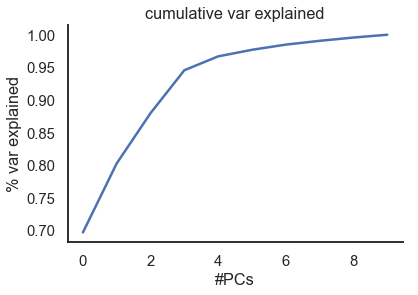

In [16]:
plt.plot(np.cumsum(pca.explained_variance_ / np.sum(pca.explained_variance_)))
plt.title('cumulative var explained')
plt.xlabel('#PCs')
plt.ylabel('% var explained')
sns.despine()

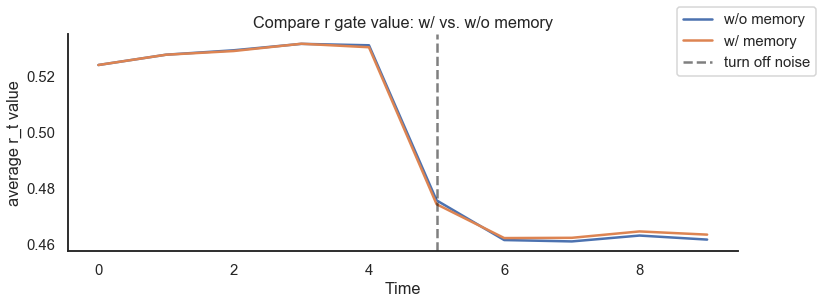

In [15]:
f, ax = plt.subplots(1,1, figsize=(12,4))

gate_plt = r_t

g_t_val_1 = np.mean(np.mean(np.array(gate_plt[:M]),axis=-1),axis=0)
g_t_val_2 = np.mean(np.mean(np.array(gate_plt[M:]),axis=-1),axis=0)

ax.plot(g_t_val_1, label='w/o memory')
ax.plot(g_t_val_2, label='w/ memory')

ax.axvline(tp_corrupt, color='black', linestyle='--', alpha=.5, label='turn off noise')

ax.set_ylabel('average r_t value')
ax.set_xlabel('Time')
ax.set_title('Compare r gate value: w/ vs. w/o memory')

f.legend()

sns.despine()